In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 1024#256#512

nTime = nLat
nSimTime = nLat*50#2048
lSim = 0
nSims = 5#00

phi0 = 1.
m2eff = 1.
lamb = 1.
lenLat = 100.;
phi_initial = 0
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
step = 1
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha*step

### Theoretical Field PS 

In [4]:
# field spectrum
# prediction from lattice renormalization

norm = lambda phi: 1./ phi / np.sqrt(2.*lenLat)
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
omega = lambda m2: np.sqrt(freqs**2. + m2)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, m2, tem: norm(phi) * np.sqrt(2./(np.exp(omega(m2)/tem) - 1.)) / np.sqrt(omega(m2))
pspec = lambda phi, m2, tem, sigma: np.abs(spectral_field(phi, m2, tem) * Filter(sigma))**2.
sigma0sq_th = lambda phi, m2, tem, sigma: np.sum(pspec(phi, m2, tem, sigma))

V = lambda x, m2, lam, gam: (- 0.5 * m2 * x**2. + lam * x**4. / 24. - gam * x) if gam == 0.25 else (- 0.5 * m2 * x**2. + lam * x**4. / 24. - gam * x**3. / 6. if x < 0. else - 0.5 * m2 * x**2. + lam * x**4. / 24.) if gam == 0.5 else (- 0.5 * m2 * x**2. + lam * x**4. / 24.) if gam == 0. else (0.5 * m2 * x**2. + lam * x**4. / 24.)
VVVV = lambda lam: lam

deltam2th = lambda phi, lam, m2, tem, sigma: 0.5 * VVVV(lam) * sigma0sq_th(phi, m2, tem, sigma)
deltam2 = lambda gam, lam, tem: 0.5 * VVVV(lam) * np.mean(all_data[tem, gam, :, 0, 0]**2.)

th_masses = lambda gam, phi, lam, tem, m2, sigma: (m2 if gam == -1. else -m2) + deltam2th(phi, lam, m2, tem, sigma)
masses_from_data_ps = lambda gam, lam, tem, m2: (m2 if gam == 0 else -m2) + deltam2(gam, lam, tem)

In [5]:
#dataPS = lambda sim, time: np.abs(np.fft.fftshift(np.fft.ifft(all_data[tem][0][sim][0][time])))**2.
#for tem in range(len(list_temp)):
#    plt.plot(freqs, pspec(phi0, m2eff, list_temp[tem], 0.))
#    plt.plot(freqs, np.mean([dataPS(sim, 0) for sim in range(nSims-lSim)], axis=0), 'o', ms=2)
#    plt.show()

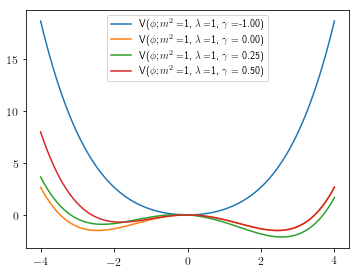

In [6]:
xlist = np.linspace(-4, 4, 100)
m2eff = 1.
lamb = 1.
plt.figure()
[plt.plot(xlist, [V(x, m2eff, lamb, gam) for x in xlist], label=f'V($\phi; m^2 = $%1.f, $\lambda = $%1.f, $\gamma = $%5.2f)'%(m2eff, lamb, gam)) for gam in [-1, 0, 0.25, 0.5]]
plt.legend(); plt.show()

### Extract data from files

In [7]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, phi, lam, m2, gam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, m2, gam, tem: '_for_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_m2{:.4f}'.format(m2)+'_gam{:.4f}'.format(gam)

In [8]:
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))
list_thresh = lambda tem, sigma: np.arange(1, 500)/100*sigma0_th(tem, sigma)

def extract_sim(nT, nL, tem, phi, lam, m2, gam, sim, sigma=0.):
    data = np.genfromtxt(sim_location((nSimTime if gam >= 0. else nTime), nL, tem, phi, lam, m2, gam, sim))
#    print(tem, phi, lam, m2, gam, sim)
    simulation = [[]]*nCols
    for col in range(nCols):
        simulation[col] = np.reshape(data[:,col], (nT, nL))
    if sigma != 0:
        for col in range(nCols):
            simulation[col] = np.asarray([smoothen(slic, sigma) for slic in simulation[col]])
    return np.asarray(simulation)[:, -nL:, :]

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [9]:
list_gamma = [-1., 0.]#, 0.25, 0.5]#, 0.5]#[-1., 0., 0.25, 0.5]
list_temp = (np.arange(1, 2)/10).tolist() + (np.arange(5, 81, 5)/10.).tolist(); print(list_temp)

filter_size = 0.

[0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]


In [10]:
all_data = np.asarray([[[extract_sim(nTime, nLat, temp, phi0, lamb, m2eff, gamma, sim, filter_size) for sim in range(lSim, nSims)] for gamma in list_gamma] for temp in list_temp])

In [11]:
np.shape(all_data)

(17, 2, 5, 2, 1024, 1024)

2


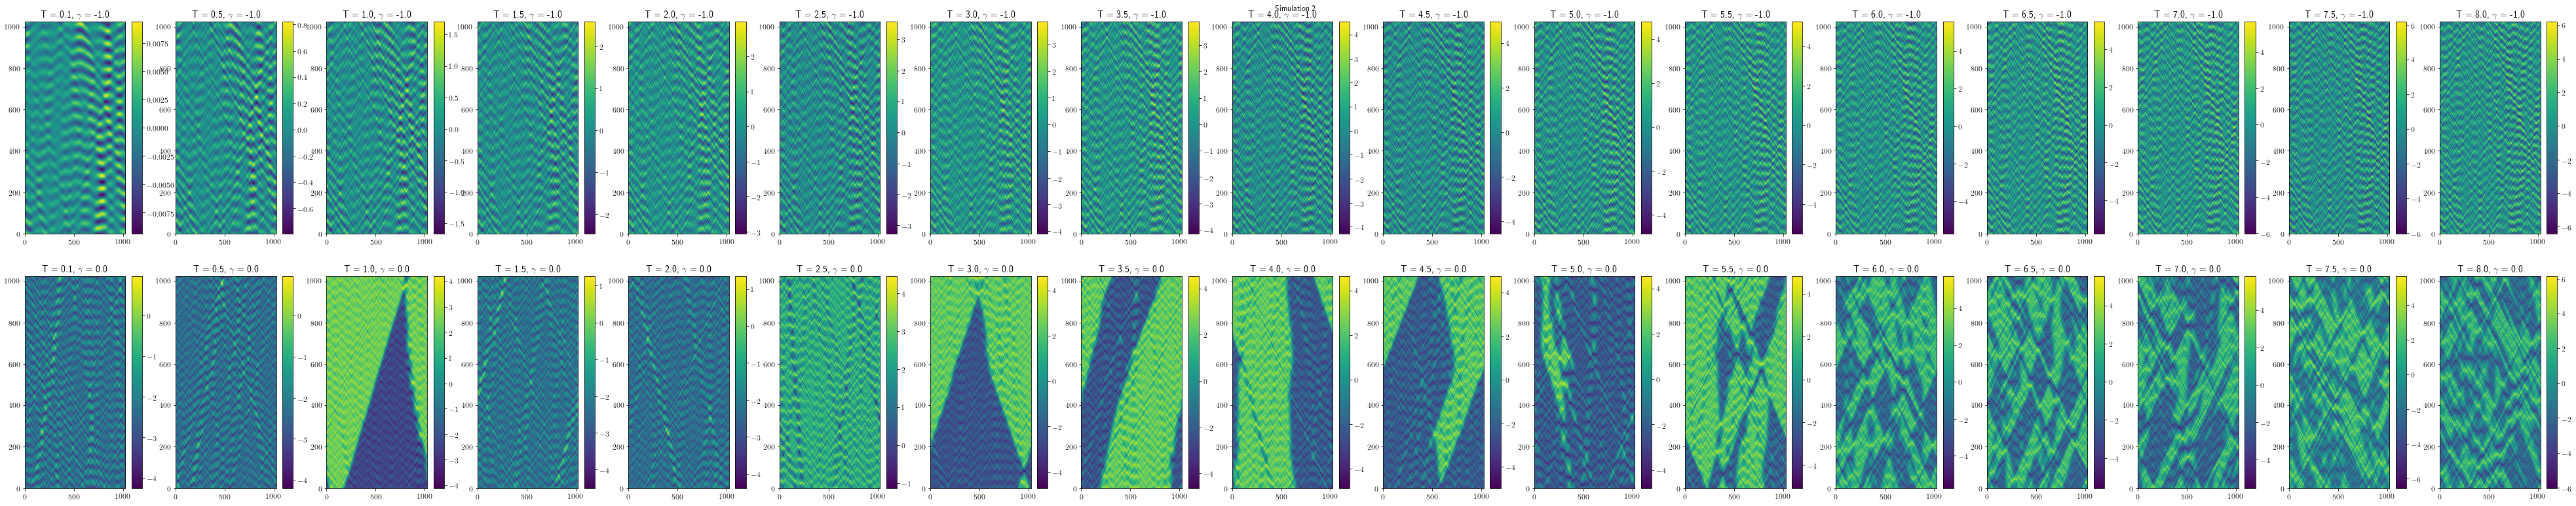

In [12]:
sim = random.randint(0, nSims-lSim-1); print(sim)

fig, ax = plt.subplots(len(list_gamma), len(list_temp), figsize = (4*len(list_temp)+4, 4*len(list_gamma)+4))
for gamma in range(len(list_gamma)):
    for temp in range(len(list_temp)):
        im0 = ax[gamma][temp].imshow(all_data[temp][gamma][sim][0], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[gamma][temp])
        ax[gamma][temp].set_title('T = '+str(list_temp[temp])+f', $\gamma$ = '+str(list_gamma[gamma]))
plt.suptitle('Simulation '+str(sim))
plt.show()

In [ ]:
from scipy import stats

gamma = -1
time = -1

for temp in range(len(list_temp)):
    PDF1d = []
    for sim in range(nSims-lSim):
        PDF1d = all_data[temp][gamma][sim][0][time]
    plt.hist(PDF1d, bins=100)
    k2, p = stats.normaltest(PDF1d)
    print("p = {:g}".format(p))
    alpha = 1e-3
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("Field is not Gaussian.")
    else:
        print("Field may be Gaussian.")

p = 7.88243e-33
Field is not Gaussian.
p = 3.52868e-72
Field is not Gaussian.
p = 1.1919e-13
Field is not Gaussian.
p = 0.0211848
Field may be Gaussian.
p = 2.92396e-208
Field is not Gaussian.
p = 0.88659
Field may be Gaussian.
p = 0
Field is not Gaussian.
p = 6.83583e-05
Field is not Gaussian.
p = 2.75898e-57
Field is not Gaussian.
p = 2.00074e-31
Field is not Gaussian.
p = 0
Field is not Gaussian.
p = 1.99404e-278
Field is not Gaussian.
p = 5.08018e-26
Field is not Gaussian.
p = 1.593e-11
Field is not Gaussian.
p = 2.4951e-32
Field is not Gaussian.
p = 2.07057e-08
Field is not Gaussian.
p = 9.73343e-67
Field is not Gaussian.


In [ ]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses(bool, multiplier, gam):
    PSPECS, masses = [[]]*all_data.shape[0], [[]]*all_data.shape[0]
    for temp in range(len(list_temp)):
        for sim in range(0, nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            simulation = simulation - np.mean(simulation)
            PSPECS[temp].append(np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.)

        PSPECS[temp] = np.mean(PSPECS[temp], axis = 0)
        T, N = PSPECS[temp].shape
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi

        p1, p2, p3 = 1., 1., 0.1
        KK, OO = np.meshgrid(kk,oo)
        coords = lambda ppp3: ((KK/p1)**2 - (OO/p2)**2 <= -(ppp3)**2)
        cdsnot = lambda ppp3: ((KK/p1)**2 - (OO/p2)**2 >= -(ppp3)**2)

        maxVal = np.mean(PSPECS[temp]) + multiplier * np.std(PSPECS[temp])
        #PSPECS[temp] = PSPECS[temp]*coords(p3)
        osccoords = np.argwhere(PSPECS[temp] > maxVal)

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        masses[temp] = popt[-1]
        if masses[temp] < 0: masses[temp] = 'nan'

        if bool:
            lim = 16
            fig, ax = plt.subplots(1, 2, figsize = (10, 3.5))
            ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
            ax[0].set_xlim(-lim,lim); ax[0].set_ylim(0,lim)
            ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            lim = 4
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', label=f'$m^2=$%5.5f'%popt[-1])
            im = ax[1].imshow(PSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[1].imshow(np.amax(PSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[1])
            ax[1].set_title('T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[1].set_xlabel(r'$\bar{k}$'); ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_ylim(0,lim); ax[1].set_xlim(-lim,lim)
            ax[1].axvline(0, color='white', ls=':'); ax[1].axhline(0, color='white', ls=':')
            [i.legend() for i in ax]; plt.show()
    return masses

In [ ]:
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))

fine_temp_list = np.linspace(min(list_temp), max(list_temp), 100)

multiplier = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for gam in range(len(list_gamma[:])):
    print(f'$\gamma = $', list_gamma[gam])
    col = next(colors)
    masses = get_masses(False, multiplier, gam)
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], phi0, lamb, m2eff, tem, 0.)) for tem in fine_temp_list], color=col, label='prediction')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title('multiplier = '+str(multiplier))
plt.ylabel(f'$m^2(T, \gamma)$')
plt.xlabel(f'$T$')
plt.legend()
plt.show()

TypeError: <lambda>() takes 2 positional arguments but 4 were given

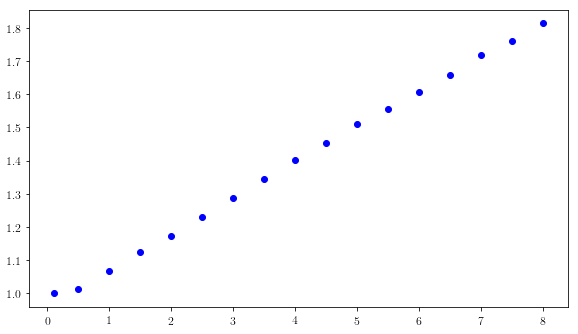

In [60]:
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))

multiplier = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for gam in range(len(list_gamma[:])):
    col = next(colors)
    masses = get_masses(False, multiplier, gam)
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(list_temp, [np.abs(masses_from_data_ps(gam, lamb, tem, m2eff)) for tem in range(len(list_temp))], color=col, label='prediction')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title('multiplier = '+str(multiplier))
plt.ylabel(f'$m^2(T, \gamma)$')
plt.xlabel(f'$T$')
plt.legend()
plt.show()

In [ ]:
gam = 0
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for multiplier in range(0, 5, 1):
    multiplier = multiplier
    col = next(colors)
    masses = get_masses(False, multiplier, gam)
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=col, label='multiplier = '+str(multiplier))

plt.plot(list_temp, [np.abs(masses_from_data_ps(gam, lamb, tem, m2eff)) for tem in range(len(list_temp))], color=next(colors), label='prediction')
plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title(f'$\gamma$ = '+str(list_gamma[gam]))
plt.ylabel(f'$m^2(T, \gamma)$')
plt.xlabel(f'$T$')
plt.legend()
plt.show()

# Evaluate m^2 per sim, then average 

In [61]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses_per_sim(bool, multiplier, gam):
    masses = np.asarray([[[0.]]*all_data.shape[2]]*all_data.shape[0])
    for temp in range(len(list_temp)):
        for sim in range(nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            T, N = simulation.shape
            simulation = simulation - np.mean(simulation)

            kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
            oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
            #k = np.fft.fftshift(np.fft.fftfreq(N))*N
            #o = np.fft.fftshift(np.fft.fftfreq(T))*T

            pspec_sim = np.abs(np.fft.fftshift(np.fft.ifft2(simulation)))**2.
            maxVal = np.mean(pspec_sim) + multiplier * np.std(pspec_sim)
            osccoords = np.argwhere(pspec_sim > maxVal)

            try:
                popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
                masses[temp][sim] = popt[-1]
                if masses[temp][sim] < 0: masses[temp][sim] = 'nan'
            except TypeError:
                masses[temp][sim] = 'nan'
                continue

            if bool and sim == 0:
                lim = 16
                fig, ax = plt.subplots(1, 2, figsize = (10, 3.5))
                ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
                ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$m^2=$%5.5f'%popt[-1])
                ax[0].set_xlim(-lim,lim); ax[0].set_ylim(0,lim)
                ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
                ax[0].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

                lim = 4
                ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', label=f'$m^2=$%5.5f'%popt[-1])
                im = ax[1].imshow(pspec_sim, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                clb = plt.colorbar(im, ax = ax[1])
                ax[1].set_title('Sim '+str(sim)+': T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
                ax[1].set_xlabel(r'$\bar{k}$'); ax[1].set_ylabel(r'$\bar{\omega_k}$')
                ax[1].set_ylim(0,lim); ax[1].set_xlim(-lim,lim)
                ax[1].axvline(0, color='white', ls=':'); ax[1].axhline(0, color='white', ls=':')
                [i.legend() for i in ax]; plt.show()
    return masses

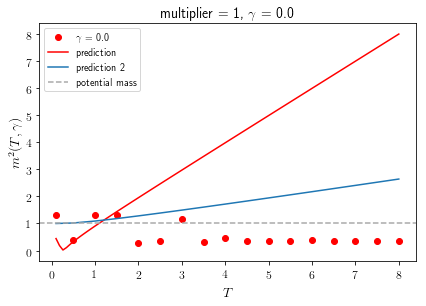

In [62]:
multiplier = 1
gam = 1
masses = np.nanmean(get_masses_per_sim(False, multiplier, gam), axis=1)

fig, ax = plt.subplots(1, 1, figsize = (7, 4))
plt.plot(list_temp, masses, 'ro', linestyle='None', label=f'$\gamma$ = '+str(list_gamma[gam]))
plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], phi0, lamb, m2eff, tem, 0.)) for tem in fine_temp_list], 'r', label='prediction')
masses_from_data_ps = lambda gam, tem: m2eff + 0.5 * VVVV(lamb) * np.mean(classical_field(gam, tem)[0]**2.)
plt.plot(list_temp, [np.abs(masses_from_data_ps(gamma, tem)) for tem in list_temp], label='prediction 2')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title('multiplier = '+str(multiplier)+f', $\gamma$ = '+str(list_gamma[gam]))
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()

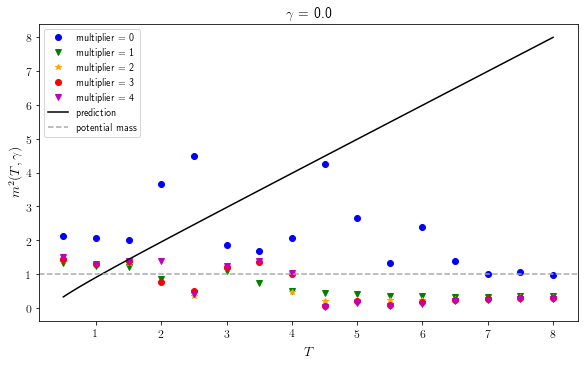

In [19]:
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))

gam = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for multiplier in range(5):
    masses = np.ndarray.flatten(np.nanmean(get_masses_per_sim(False, multiplier, gam), axis=1))
    plt.plot(list_temp, masses, marker=next(marks), linestyle='None', color=next(colors), label='multiplier = '+str(multiplier))

plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], phi0, lamb, m2eff, tem, 0.)) for tem in fine_temp_list], color=next(colors), label='prediction')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title(f'$\gamma$ = '+str(list_gamma[gam]))
plt.ylabel(f'$m^2(T, \gamma)$'); plt.xlabel(f'$T$')
plt.legend(); plt.show()

### Get profile of omega ^2

0.1 -1.0


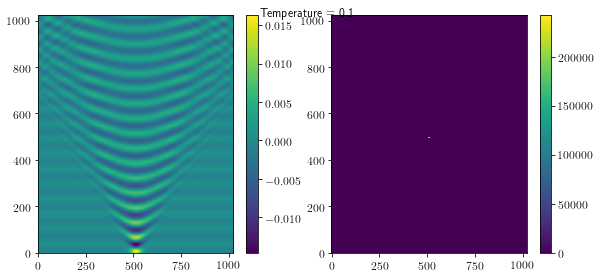

In [47]:
classical_field = lambda gam, tem: np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_m21.0000_gam{:.4f}'.format(gam)+'_t1024_x1024_temp{:.4f}'.format(tem)+'_phi01.0000_lamb1.0000_fields.dat'), (nTime, nLat)))

gamma = list_gamma[0]
for temp in list_temp[::100]:
    print(temp, gamma)
    field = classical_field(gamma, temp)
    field = np.asarray([np.roll(slice, nLat//2) for slice in field])
    fftfield = np.abs(np.fft.fftshift(np.fft.fft2(field)))**2.
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    im = ax[0].imshow(field, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[0])
    im = ax[1].imshow(fftfield, aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[1])
    plt.suptitle('Temperature = '+str(temp))
    plt.show()

Text(0, 0.5, '$|\\phi_k|^2$')

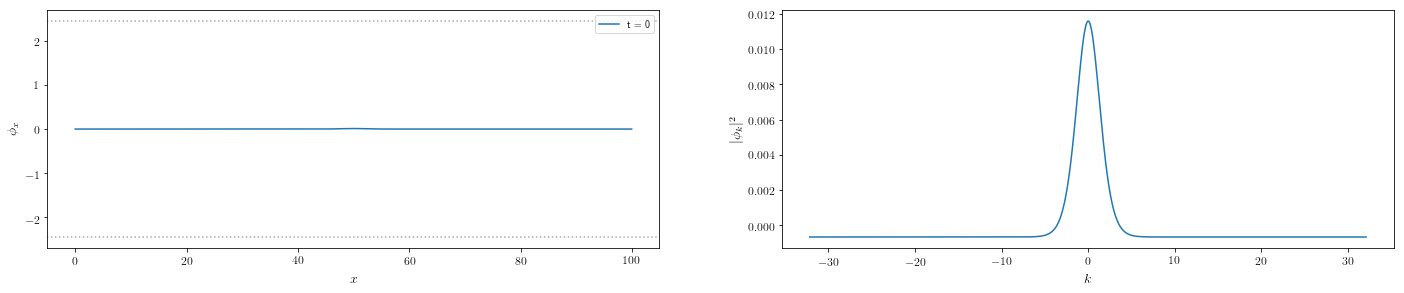

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (25, 4))
for time in np.linspace(0, 50, 1):
    time = int(time)
    ax[0].plot(np.arange(nLat)*dx, field[time], label='t = '+str(time))
    ax[1].plot(freqs, field[time], label='t = '+str(time))
ax[0].legend()
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[1].set_xlabel(f'$k$')
ax[1].set_ylabel(f'$|\phi_k|^2$')

Text(0, 0.5, '$|\\phi_k|^2$')

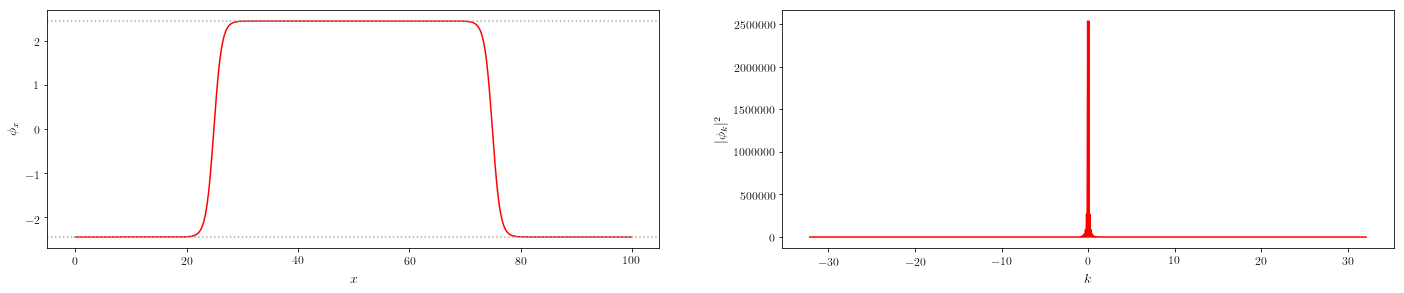

In [55]:
wall_profile = np.mean(np.asarray(np.reshape(np.genfromtxt('/gpfs/dpirvu/thermal_bubbles/phi4_gam0.0000_t1024_x1024_fields.dat'), (nTime, nLat))), axis=0)
wall_PS = np.abs(np.fft.fftshift(np.fft.fft(wall_profile)))**2.
fig, ax = plt.subplots(1, 2, figsize = (25, 4))
ax[0].plot(np.arange(nLat)*dx, wall_profile, 'r')
ax[0].set_xlabel(f'$x$')
ax[0].set_ylabel(f'$\phi_x$')
ax[0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
ax[1].plot(freqs, wall_PS, 'r')
ax[1].set_xlabel(f'$k$')
ax[1].set_ylabel(f'$|\phi_k|^2$')

In [ ]:
def get_pspec(gam, tem, thresh):
    pspecs, saves = [], []
    for sim in range(0, nSims-lSim):
        simulation = all_data[tem][gam][sim][0]
        T, N = simulation.shape
        simulation = simulation - np.mean(simulation)
        pspecs.append(np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.)

    pspecs = np.mean(pspecs, axis = 0)
    T, N = pspecs.shape
    kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
    saves = pspecs[oo==0., kk>0]
    pspecs = pspecs[:, (kk>0)&(kk<thresh)]
#    print(kk[(kk>0)&(kk<thresh)])
    return np.mean(pspecs, axis=1), saves, kk


thresh = 0.5;
gam = 1

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
fig, ax = plt.subplots(1, 2, figsize = (25, 5))
for tem in range(0, len(list_temp), 3):
    av_PS, saves, kk = get_pspec(gam, tem, thresh)   
    col = next(colors)
    
    ax[0].plot(freqs[(kk>0)&(kk<5)], av_PS[(kk>0)&(kk<5)], label=f'$T$ = '+str(list_temp[tem]), color=col)
    ax[1].plot(freqs[freqs>0], saves, label=f'$T$ = '+str(list_temp[tem]), color=col)

ax[1].set_yscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(f'$\omega_k$')
ax[1].set_xlabel(f'$k$')
[i.set_ylabel(f'$|FFT(\phi_x)|^2$') for i in ax]
[i.legend() for i in ax]
plt.suptitle(f'$\gamma$ = '+str(list_gamma[gam]))
plt.show()

### Separate Real and Imaginary Contributions to PS

In [80]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses_seps(bool, multiplier, gam):
    rePSPECS, imPSPECS, remasses, immasses = [[]]*all_data.shape[0], [[]]*all_data.shape[0], [[]]*all_data.shape[0], [[]]*all_data.shape[0]
    for temp in range(len(list_temp)):
        for sim in range(0, nSims-lSim):
            simulation = all_data[temp][gam][sim][0]
            simulation = simulation - np.mean(simulation)
            fftfield = np.fft.fftshift(np.fft.fft2(simulation))
            rePSPECS[temp].append(np.abs(fftfield.real)**2.)
            imPSPECS[temp].append(np.abs(fftfield.imag)**2.)

        rePSPECS[temp] = np.mean(rePSPECS[temp], axis = 0)
        imPSPECS[temp] = np.mean(imPSPECS[temp], axis = 0)
        T, N = rePSPECS[temp].shape
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi

        p1, p2, p3 = 1., 1., 0.1
        KK, OO = np.meshgrid(kk,oo)
        coords = lambda ppp3: ((KK/p1)**2 - (OO/p2)**2 <= -(ppp3)**2)
        cdsnot = lambda ppp3: ((KK/p1)**2 - (OO/p2)**2 >= -(ppp3)**2)

        remaxVal = np.mean(rePSPECS[temp]) + multiplier * np.std(rePSPECS[temp])
        immaxVal = np.mean(imPSPECS[temp]) + multiplier * np.std(imPSPECS[temp])
        print(remaxVal, immaxVal)
        #PSPECS[temp] = PSPECS[temp]*coords(p3)
        reosccoords = np.argwhere(rePSPECS[temp] > remaxVal)
        imosccoords = np.argwhere(imPSPECS[temp] > immaxVal)

        remasses[temp], _ = sco.curve_fit(omega_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)
        immasses[temp], _ = sco.curve_fit(omega_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)

        if bool:
            lim = 16
            fig, ax = plt.subplots(1, 4, figsize = (22, 4))
            ax[0].plot(kk[reosccoords[:,1]], oo[reosccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*remasses[temp])), label=f'$m^2=$%5.5f'%remasses[temp])
            ax[0].set_xlim(-lim,lim)
            ax[0].set_ylim(0,lim)
            ax[0].set_title('Real T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[0].axhline(remasses[temp], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            ax[2].plot(kk[imosccoords[:,1]], oo[imosccoords[:,0]], 'o', ms=5, label='freqs')
            ax[2].plot(kk, np.sqrt(omega_fit(kk,*immasses[temp])), label=f'$m^2=$%5.5f'%immasses[temp])
            ax[2].set_xlim(-lim,lim)
            ax[2].set_ylim(0,lim)
            ax[2].set_title('Imaginary T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[2].axhline(immasses[temp], color='darkgray', ls=':', label='best fit')
            ax[2].axhline(m2eff, color='darkgray', ls='-.', label='potential mass')

            lim = 4
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*remasses[temp])), color = 'y', label=f'$m^2=$%5.5f'%remasses[temp])
            im = ax[1].imshow(rePSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[1].imshow(np.amax(rePSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[1])
            ax[1].set_title('Real T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[1].set_xlabel(r'$\bar{k}$')
            ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].set_xlim(-lim,lim)
            ax[1].set_ylim(0,lim)
            ax[1].axvline(0, color='white', ls=':')
            ax[1].axhline(0, color='white', ls=':')
            
            ax[3].plot(kk, np.sqrt(omega_fit(kk,*immasses[temp])), color = 'y', label=f'$m^2=$%5.5f'%immasses[temp])
            im = ax[3].imshow(imPSPECS[temp], aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            #ax[3].imshow(np.amax(imPSPECS[temp])/2.*(coords(p3) & cdsnot(p3+0.2)), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
            clb = plt.colorbar(im, ax = ax[3])
            ax[3].set_title('Imaginary T = '+str(list_temp[temp])+f', $\gamma = $'+str(list_gamma[gam]))
            ax[3].set_xlabel(r'$\bar{k}$')
            ax[3].set_ylabel(r'$\bar{\omega_k}$')
            ax[3].set_xlim(-lim,lim)
            ax[3].set_ylim(0,lim)
            ax[3].axvline(0, color='white', ls=':')
            ax[3].axhline(0, color='white', ls=':')
            [i.legend() for i in ax]; plt.show()
    return remasses, immasses

$\gamma = $ -1.0
3282498.288469937 2600206.909279283
6023002.797784545 5334128.741281542
8729794.19790735 7769868.100150568
10361076.077238271 9267474.750897866
10888363.472602447 10788214.629878862
12498029.134396289 11864530.624350807
13374857.55379678 13363669.543362122
14635094.945651362 14483303.35403834
15470517.944981193 15622978.886341803
16659706.682009863 16305074.264081419
17431135.57353422 17431218.926767714
18179005.84166368 18398975.731371116
19245971.687470727 19066775.56971567
20003213.336101767 19990781.00873468
20846871.172623966 20767986.328598764
21636352.54035546 21566738.445198953


IndexError: index 16 is out of bounds for axis 0 with size 16

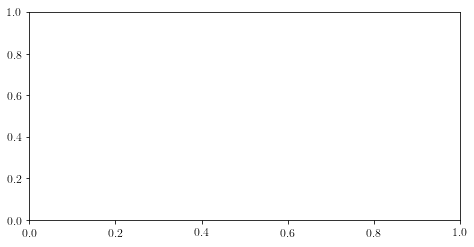

In [81]:
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v'))

multiplier = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
for gam in range(len(list_gamma[:])):
    print(f'$\gamma = $', list_gamma[gam])
    col = next(colors)
    remasses, immasses = get_masses_seps(False, multiplier, gam)
    plt.plot(list_temp, remasses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(list_temp, immasses, marker=next(marks), linestyle='None', color=col, label=f'$\gamma$ = '+str(list_gamma[gam]))
    plt.plot(fine_temp_list, [np.abs(th_masses(list_gamma[gam], phi0, lamb, m2eff, tem, 0.)) for tem in fine_temp_list], color=col, label='prediction')

plt.axhline(m2eff, color='darkgray', ls='--', label='potential mass')
plt.title('multiplier = '+str(multiplier))
plt.ylabel(f'$m^2(T, \gamma)$')
plt.xlabel(f'$T$')
plt.legend()
plt.show()